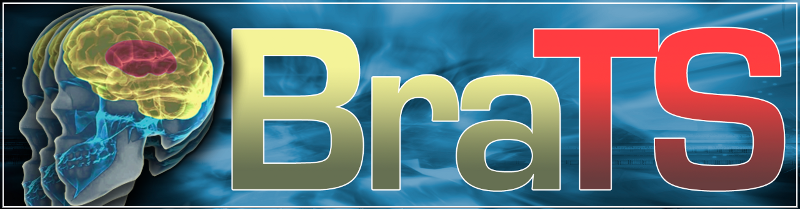

# Introduction

Today, an estimated 700,000 people in the United States are living with a primary brain tumor, and approximately 85,000 more will be diagnosed in 2021. Brain tumors can be deadly, significantly impact quality of life, and change everything for a patient and their loved ones.

Brain tumor has a lasting and psychological impact on patient life. The Brain tumor is caused by tissue abnormality that develops within the brain or in the central spine, interrupting proper brain function. A Brain tumor is marked as Benign and Malignant. Benign brain tumors do not contain cancer cells and grow gradually. They do not spread and commonly stay in one region of the brain, whereas malignant brain tumors contain cancer cells and grow quickly and spread through to other brain and spine regions as well. 

Glioblastoma (GBM), and diffuse astrocytic glioma are the most common and aggressive malignant primary tumor of the central nervous system (CNS) in adults, with extreme intrinsic heterogeneity in appearance, shape, and histology. GBM patients have an average prognosis of 14 months (following standards of care treatment comprising surgical resection followed by radiotherapy and chemotherapy), and 4 months left untreated.

Currently, genetic analysis of cancer requires surgery to extract a tissue sample. Then it can take several weeks to determine the genetic characterization of the tumor. Depending on the results and type of initial therapy chosen, a subsequent surgery may be necessary. If an accurate method to predict the genetics of the cancer through imaging (i.e. radiogenomics) alone could be developed, this would potentially minimize the number of surgeries and refine the type of therapy required. 

# Business Problem

The goal is to build an accurate model which segments the brain tumor in the given MRI image from BraTS2020 Dataset and further 

What is MGMT?
** MGMT (O[6]-methylguanine-DNA methyltransferase) is a DNA repair enzyme. This enzyme rescues tumor cells from alkylating agent-induced damage, leading to chemotherapy resistance with alkylating agents. Patients with glioblastoma containing a methylated MGMT promoter benefited from temozolomide, whereas those who did not have a methylated MGMT promoter did not have such a benefit.


# Dataset

In [ ]:
# https://www.med.upenn.edu/cbica/brats2020/data.html
# https://www.kaggle.com/andrewmvd/brain-tumor-segmentation-in-mri-brats-2015  (Only 2020 training Data files considered from here)

**Survival Data Description**
  
  The overall survival (OS) data, defined in days, are included in a
  comma-separated value (.csv) file with correspondences to the
  pseudo-identifiers of the imaging data. The .csv file also includes the age
  of patients, as well as the resection status. **Note** that only subjects
  with resection status of GTR (i.e., Gross Total Resection) will be evaluated
  and you are only expected to send your predicted survival data for those
  subjects.

**Imaging Data Description**

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and of 4 modalities as follows:
* T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 
  1–6 mm slice thickness.
* T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D
  acquisition and 1 mm isotropic voxel size for most patients.
* T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
* FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D
  acquisitions, 2–6 mm slice thickness.

---

---

All images were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.
All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise 
* Label0: Unlabeled volumne
* Label1: Necrotic and non-enhancing tumor core(NCR/NET)
* Label2: Peritumoral edema(ED)
* Label3: Missing( No Pixels in all the volumes contain label 3)
* Label4: GD-enhancing tumor (ET)


---


Let's look into the Constituents of Glioma:

-- Edema: Collection of fluid over water, Best seen in FLAIR and T2  
   weighted sequence. Fingerlike Projection.

-- Necrosis: Accumulation of dead cells. Best seen in T1 post contrast  
   sequence.

-- Enhancing Tumor: Indicate breakdown of blook brain barrier. Seen in T1c
   post contrast sequence.

-- Non Enhancing: Regions in region that are neither edema, necrosis or 
   enhancing tumor.


In [1]:
%config Completer.use_jedi = False #Autocomplete

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pathlib
import nibabel as nib
import glob
import re
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

!pip install SimpleITK
import SimpleITK as sitk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm
import gzip

# !pip install split-folders
# import splitfolders
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, concatenate, Conv3D, Conv3DTranspose, MaxPooling3D, BatchNormalization, Dropout, Cropping3D, UpSampling3D, Conv2D, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


     |████████████████████████████████| 48.4 MB 2.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(survival_data_2020.shape)
survival_data_2020

We are provided with Survival Info for 236 patients, however 369 MRI scans are present in 2020 Dataset.

In [ ]:
survival_data_2020['Extent_of_Resection'].value_counts()

GTR    119
STR     10
Name: Extent_of_Resection, dtype: int64

In [ ]:
##loading 2020 training Dataset

t1_images= (glob.glob("/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/*/*t1.nii"))
t1ce_images = (glob.glob("/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii"))
flair_images = (glob.glob("/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/*/*flair.nii"))
t2_images = (glob.glob("/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/*/*t2.nii"))
seg_images = (glob.glob("/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/*/*seg.nii"))
print(len(t1_images), len(t1ce_images), len(flair_images), len(t2_images), len(seg_images))

The count of images isn't same in 2020 dataset. It seems ,we have 1 segmentation image missing. Lets Check..

In [ ]:
t1_order= set(sorted(pd.Series(t1_images).apply(lambda x:x.split('/')[-1].split("_")[-2])))
seg_order= sext(sorted(pd.Series(seg_images).apply(lambda x:x.split('/')[-1].split("_")[-2])))
print("Segmentation Image no. missing in Seg_images List: ",[i for i in t1_order if i not in seg_order])

In [ ]:
print(os.listdir(data_dir+ "MICCAI_BraTS2020_TrainingData/BraTS20_Training_355"))
print("changing the name of segmentation_355 file in the seg_images_list\n")
#moved file from kaggle input to working directory
# os.rename("/kaggle/working/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii","/kaggle/working/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii")

#index of seg image missing in seg_images list 
[i.split("/")[-2] for i in t1_images].index('BraTS20_Training_355')
os.listdir(data_dir+ "MICCAI_BraTS2020_TrainingData/BraTS20_Training_355")
seg_images.insert(366, 'W39_1998.09.19_Segm.nii')
len(seg_images)

The count of seg_images is 368, while for others it is 369.

In [ ]:
data= pd.DataFrame()
data['t1_images']= t1_images
data['t1ce_images'] = t1ce_images
data['t2_images'] = t2_images
data['flair_images'] = flair_images
data['seg_images'] = seg_images

print(data.shape)
data.head()

(369, 5)


t1_images  \
0  /kaggle/input/brain-tumor-segmentation-in-mri-...   
1  /kaggle/input/brain-tumor-segmentation-in-mri-...   
2  /kaggle/input/brain-tumor-segmentation-in-mri-...   
3  /kaggle/input/brain-tumor-segmentation-in-mri-...   
4  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                         t1ce_images  \
0  /kaggle/input/brain-tumor-segmentation-in-mri-...   
1  /kaggle/input/brain-tumor-segmentation-in-mri-...   
2  /kaggle/input/brain-tumor-segmentation-in-mri-...   
3  /kaggle/input/brain-tumor-segmentation-in-mri-...   
4  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                           t2_images  \
0  /kaggle/input/brain-tumor-segmentation-in-mri-...   
1  /kaggle/input/brain-tumor-segmentation-in-mri-...   
2  /kaggle/input/brain-tumor-segmentation-in-mri-...   
3  /kaggle/input/brain-tumor-segmentation-in-mri-...   
4  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                        flair_images  \
0  /kaggle/input/brain-tumor-segmentation-in-mri-...   
1  /kaggle/input/brain-tumor-segmentation-in-mri-...   
2  /kaggle/input/brain-tumor-segmentation-in-mri-...   
3  /kaggle/input/brain-tumor-segmentation-in-mri-...   
4  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                          seg_images  
0  /kaggle/input/brain-tumor-segmentation-in-mri-...  
1  /kaggle/input/brain-tumor-segmentation-in-mri-...  
2  /kaggle/input/brain-tumor-segmentation-in-mri-...  
3  /kaggle/input/brain-tumor-segmentation-in-mri-...  
4  /kaggle/input/brain-tumor-segmentation-in-mri-...

# EDA

# Survival Days Distribution

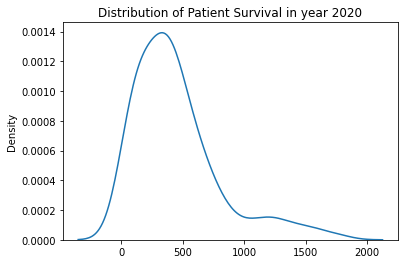

In [ ]:
list(survival_data_2020['Survival_days'].values).index('ALIVE (361 days later)')
survival_data_2020['Survival_days'].values[83]=361

sns.kdeplot(survival_data_2020['Survival_days'].values.astype('int'))
plt.title("Distribution of Patient Survival in year 2020")
plt.show()

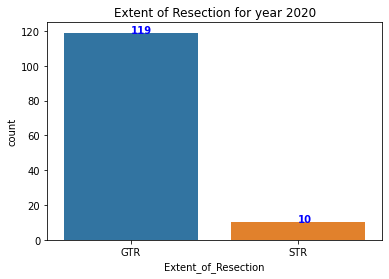

In [ ]:
#Since only GTR resection images needs to be considered
#analysing the distribution of the same for year 2020

ax= sns.countplot(survival_data_2020['Extent_of_Resection'])
plt.title("Extent of Resection for year 2020")
count= 0.00
for i in ax.patches:
    plt.text(count, i.get_height(),str((i.get_height())),fontsize = 10, fontweight ='bold',color ='blue')
    count+=1
plt.show()

## Image Shapes

In [ ]:
# loading sizes of different MRI Images
t1 =sitk.ReadImage(train.values[1][0])
print("T1 :", sitk.GetArrayFromImage(t1).shape)

t2= sitk.ReadImage(train.values[1][2])
print("T2 :", sitk.GetArrayFromImage(t2).shape)

t1CE= sitk.ReadImage(train.values[1][1])
print("T1 Weighted :", sitk.GetArrayFromImage(t1CE).shape)

t2FLAIR= sitk.ReadImage(train.values[1][3])
print("T2 FLAIR :", sitk.GetArrayFromImage(t2FLAIR).shape)

seg= sitk.ReadImage(train.values[1][4])
print("Segmentation :", sitk.GetArrayFromImage(seg).shape)

T1 : (155, 240, 240)
T2 : (155, 240, 240)
T1 Weighted : (155, 240, 240)
T2 FLAIR : (155, 240, 240)
Segmentation : (155, 240, 240)


## Plot Images

### Ref: https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/

In [ ]:
sitk.GetArrayFromImage(seg).shape

(155, 240, 240)

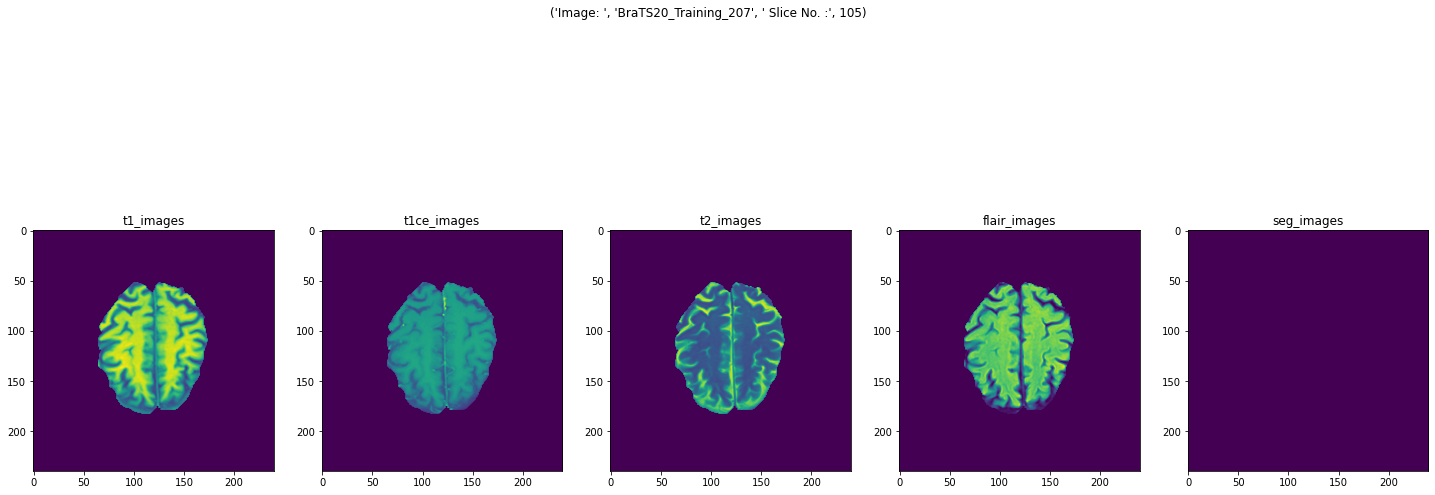

In [ ]:
import random

title= train.columns
# idx_Slice= random.randint(0, sitk.GetArrayFromImage(seg).shape[0])
idx_Slice= 105
fig, ax= plt.subplots(1,5, figsize=[25, 10])
for n, i in enumerate(train.values[10]):
    nb_file= nib.load(i).get_fdata()
    ax[n].imshow(np.rot90(nb_file[:,:,idx_Slice])) #, cmap="gray" )
    ax[n].set_title(title[n])

plt.suptitle(("Image: ", train.values[100][0].split('/')[-2], " Slice No. :", idx_Slice))
plt.show()

# Multi-Modal Segmentation

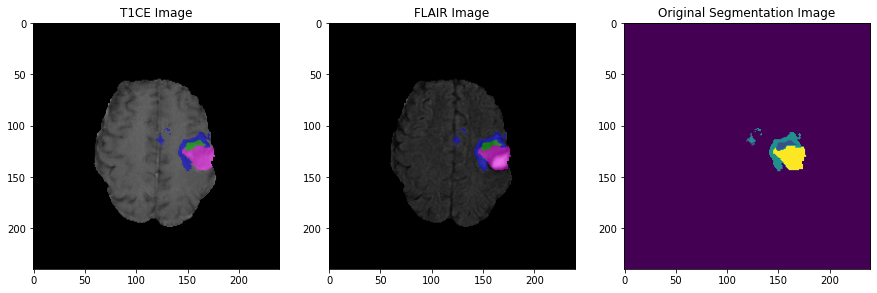

In [ ]:
imgT1Smooth = sitk.ReadImage(train.values[100][1])
imgT2Smooth = sitk.ReadImage(train.values[100][3])
seg = sitk.ReadImage(train.values[100][4])

imgGrayMatterComp=sitk.ReadImage(train.values[100][4])

# int label to assign to the segmented gray matter
labelGrayMatter = 1
lstSeeds = [(165, 178, idx_Slice),
            (98, 165, idx_Slice),
            (205, 125, idx_Slice),
            (173, 205, idx_Slice)]

imgT1Smooth = sitk.Cast(imgT1Smooth, sitk.sitkInt16)
imgT2Smooth = sitk.Cast(imgT2Smooth, sitk.sitkInt16)
imgGrayMatterComp = sitk.Cast(imgGrayMatterComp, sitk.sitkInt16)
imgComp = sitk.Compose(imgT1Smooth, imgGrayMatterComp)


imgGrayMatterComp_ = sitk.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)


imgGrayMatterT1 = sitk.ConfidenceConnected(image1=imgT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=1,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT2 = sitk.ConfidenceConnected(image1=imgT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=1,
                                                replaceValue=labelGrayMatter)


imgT1SmoothInt = sitk.Cast(sitk.RescaleIntensity(imgT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
imgT2SmoothInt = sitk.Cast(sitk.RescaleIntensity(imgT2Smooth), 
                                imgGrayMatterT2.GetPixelID())

img_1 =sitk.LabelOverlay(imgT1SmoothInt[:,:,idx_Slice], imgGrayMatterComp[:,:,idx_Slice])
img_2= sitk.LabelOverlay(imgT2SmoothInt[:,:,idx_Slice], imgGrayMatterComp[:,:,idx_Slice])

fig, ax= plt.subplots(1,3, figsize=[15, 7])
ax[0].imshow(sitk.GetArrayFromImage(img_1))
ax[0].set_title("T1CE Image")
ax[1].imshow(sitk.GetArrayFromImage(img_2))
ax[1].set_title("FLAIR Image")
ax[2].imshow(sitk.GetArrayFromImage(seg)[idx_Slice,:,:])
ax[2].set_title("Original Segmentation Image")
plt.show()


We can see that there's extra pixels around brain image, which are useless for us, so let's crop them.

## After Cropping images looks like

## PreProcessing image

In [ ]:
#Determining the contours of MRI images
image= train['flair_images'].values[0]
image= sitk.ReadImage(image)
image= sitk.GetArrayFromImage(image)
mask =image==0
coords= np.array(np.nonzero(~mask))
np.min(coords, axis=1) , np.max(coords, axis=1)

(array([ 0, 44, 53]), array([134, 213, 182]))

(128, 128, 128)


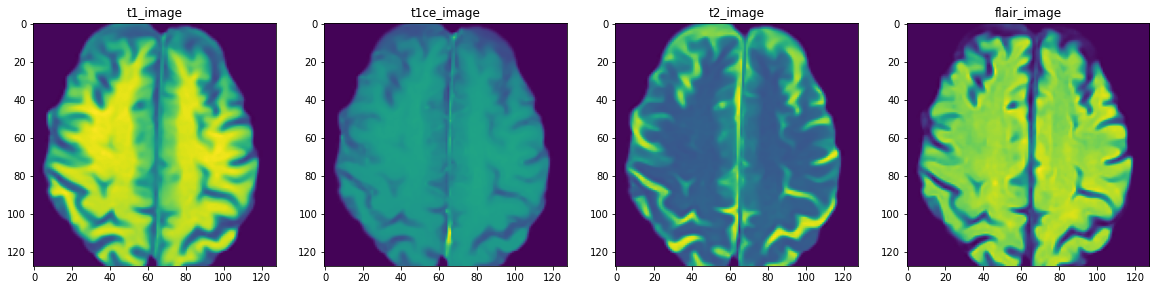

In [ ]:
#Image Preprocess
def preprocess(img_file, image_yes_no= True):
    image= sitk.ReadImage(img_file)[:,:,:]
    #converting image range to 0-255
    if image_yes_no:
        image_RGB = sitk.Cast(sitk.RescaleIntensity(image), sitk.sitkUInt8)
        #smoothing/denoising to make pixel dist more smoother
        image = sitk.CurvatureFlow(image_RGB,timeStep= 0.1, numberOfIterations=5)
    image_smooth= sitk.GetArrayFromImage(image)
    image_smooth= np.moveaxis(image_smooth, 0, -1)
    image_smooth = image_smooth[56:184, 56:184, 13:141] #Crop to 128x128x128x4
#     image_smooth = image_smooth[30:184,45:215,13:141]
    return image_smooth

idx_Slice= 90
fig, ax= plt.subplots(1, 4, figsize=(20,5))

image= preprocess(train['t1_images'].values[10])
ax[0].imshow(image[:,:, idx_Slice])
ax[0].set_title('t1_image')
image= preprocess(train['t1ce_images'].values[10])
ax[1].imshow(image[:,:, idx_Slice])
ax[1].set_title('t1ce_image')
image= preprocess(train['t2_images'].values[10])
ax[2].imshow(image[:,:, idx_Slice])
ax[2].set_title('t2_image')
image= preprocess(train['flair_images'].values[10])
ax[3].imshow(image[:,:, idx_Slice])
ax[3].set_title('flair_image')
print(image.shape)
plt.show()

We would be combining the T1CE, T2, FLAIR images together and leaving behind T1 because we can see in the visualization its may not add much value.
Also, Reassigning the label in segmentation image. We have 0,1 ,2 ,4. So, we are replacing 4 with 3.

In [ ]:
os.mkdir("/kaggle/working/BraTS2020_TrainingData/")
os.mkdir("/kaggle/working/BraTS2020_TrainingData/input_data_3channels/")
os.mkdir("/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/")
os.mkdir("/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image/")
## correcting 366 index seg image path
dir_= '/'.join(data['flair_images'][366].split("/")[:-1])
data['seg_images'][366] = dir_+'/'+ data['seg_images'][366]
data.iloc[366:,:]

t1_images  \
366  /kaggle/input/brain-tumor-segmentation-in-mri-...   
367  /kaggle/input/brain-tumor-segmentation-in-mri-...   
368  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                           t1ce_images  \
366  /kaggle/input/brain-tumor-segmentation-in-mri-...   
367  /kaggle/input/brain-tumor-segmentation-in-mri-...   
368  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                             t2_images  \
366  /kaggle/input/brain-tumor-segmentation-in-mri-...   
367  /kaggle/input/brain-tumor-segmentation-in-mri-...   
368  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                          flair_images  \
366  /kaggle/input/brain-tumor-segmentation-in-mri-...   
367  /kaggle/input/brain-tumor-segmentation-in-mri-...   
368  /kaggle/input/brain-tumor-segmentation-in-mri-...   

                                            seg_images  
366  /kaggle/input/brain-tumor-segmentation-in-mri-...  
367  /kaggle/input/brain-tumor-segmentation-in-mri-...  
368  /kaggle/input/brain-tumor-segmentation-in-mri-...

# Loading Data

In [ ]:
## Converting MRI images and masks to .npy.gz format for easy data handling and storin.
 
# !rm -rf "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"
# !rm -rf "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image/"
# os.mkdir("/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image/")
# os.mkdir("/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/")

for i in trange(data.shape[0]): #data.shape[0]
    # i=i+366
    combined_x= np.stack([preprocess(data['t1ce_images'].values[i]), preprocess(data['t2_images'].values[i]), preprocess(data['flair_images'].values[i])], axis=-1)
    mask = sitk.ReadImage(data['seg_images'].values[i])
    mask = sitk.GetArrayFromImage(mask)[56:184, 56:184, 13:141]
    mask[mask==4]=3

    val, counts = np.unique(mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
            print("Save Me")
            mask= to_categorical(mask, num_classes=4)
            f = gzip.GzipFile('/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image/image_'+str(data.values[i][0].split("/")[-2])+'.npy.gz', "w")
            np.save(file=f, arr=combined_x)
            f.close()
            f = gzip.GzipFile('/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(data.values[i][0].split("/")[-2])+'.npy.gz', "w")
            np.save(file=f, arr=mask)
            f.close()
            #             np.save('/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image/image_'+str(data.values[i][0].split("/")[-2])+'.npy', combined_x)
            #             np.save('/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(data.values[i][0].split("/")[-2])+'.npy', mask)

    else:
        print(str(data.values[i][0].split("/")[-2]), "I am useless")

In [ ]:
os.chdir("/kaggle/working/")
%cd /kaggle/working

COnverting the image and mask directory to tar format for easy download.  

In [ ]:
!tar -zcvf brats2020dataset.tar.gz /kaggle/working

### Loading Data in Colab

In [3]:
!wget --header="Host: doc-10-84-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en;q=0.9,hi-IN;q=0.8,hi;q=0.7,en-US;q=0.6,ko;q=0.5" --header="Cookie: AUTH_hjvnob1cj16m22fdup95t4vo9nf0jas6_nonce=p6flb6ms3ruam" --header="Connection: keep-alive" "https://doc-10-84-docs.googleusercontent.com/docs/securesc/2i04fc4qv450nclpvu5j1ari6q300443/q6qu68b2nvr46gptk338dnejr8jvmek5/1640542275000/03944919539948227923/03944919539948227923/1Fw_3LFWMi_x9YDsJ6lZ2by-aU2a67U5e?e=download&authuser=2&nonce=p6flb6ms3ruam&user=03944919539948227923&hash=h9kn9t0u11qlqf2bm19k6ml8j0c0vj9m" -c -O 'final_brats2020images_1.tar.gz'
!wget --header="Host: doc-14-84-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en;q=0.9,hi-IN;q=0.8,hi;q=0.7,en-US;q=0.6,ko;q=0.5" --header="Cookie: AUTH_hjvnob1cj16m22fdup95t4vo9nf0jas6=03944919539948227923|1640542275000|g8sdar4hunaksfk6755makoojaf2ht97" --header="Connection: keep-alive" "https://doc-14-84-docs.googleusercontent.com/docs/securesc/2i04fc4qv450nclpvu5j1ari6q300443/dgcoq42ifthu3lokg4q2cn9i210p2i8a/1640542275000/03944919539948227923/03944919539948227923/1tp-O1cW04ET89356kdNEtdYhcVSC8eaL?e=download&authuser=2" -c -O 'final_brats2020images_2.tar.gz'

--2021-12-26 18:12:13--  https://doc-10-84-docs.googleusercontent.com/docs/securesc/2i04fc4qv450nclpvu5j1ari6q300443/q6qu68b2nvr46gptk338dnejr8jvmek5/1640542275000/03944919539948227923/03944919539948227923/1Fw_3LFWMi_x9YDsJ6lZ2by-aU2a67U5e?e=download&authuser=2&nonce=p6flb6ms3ruam&user=03944919539948227923&hash=h9kn9t0u11qlqf2bm19k6ml8j0c0vj9m
Resolving doc-10-84-docs.googleusercontent.com (doc-10-84-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-10-84-docs.googleusercontent.com (doc-10-84-docs.googleusercontent.com)|108.177.121.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5002844932 (4.7G) [application/gzip]
Saving to: ‘final_brats2020images_1.tar.gz’

final_brats2020imag 100%[===================>]   4.66G  19.8MB/s    in 87s     

2021-12-26 18:13:40 (54.9 MB/s) - ‘final_brats2020images_1.tar.gz’ saved [5002844932/5002844932]

--2021-12-26 18:13:40--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/

In [4]:
#moving data from one folder to another, at end we will have all image and masks in one dir
os.listdir()
os.mkdir("./Brats2020Data/")
!tar -zxvf"/content/final_brats2020images_2.tar.gz" -C "/content/Brats2020Data/"
!rm -rf "/content/final_brats2020images_2.tar.gz"

os.mkdir("./Brats2020Data_2/")
!tar -zxvf"/content/final_brats2020images_1.tar.gz" -C "/content/Brats2020Data_2/"
!rm -rf "/content/final_brats2020images_1.tar.gz"

for i in os.listdir("/content/Brats2020Data_2/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image"):
  shutil.move("/content/Brats2020Data_2/kaggle/working/BraTS2020_TrainingData/input_data_3channels/image/"+i, "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image/"+i)

for i in os.listdir("/content/Brats2020Data_2/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks"):
  shutil.move("/content/Brats2020Data_2/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"+i, "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/"+i)

print(len(os.listdir("/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image")))

!rm -rf "/content/Brats2020Data_2/"

kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_262.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_339.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_023.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_205.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_206.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_053.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_274.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mask_BraTS20_Training_010.npy.gz
kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/mas

In [5]:
len(os.listdir("/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks"))

344

In [6]:
#checking the order of masks and image

os.chdir("/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/")

# print(sorted(pd.Series(os.listdir("./image")).apply(lambda x: x.split("_")[-1])) ==  sorted(pd.Series(os.listdir("./masks")).apply(lambda x: x.split("_")[-1])))

image_list = sorted(pd.Series(os.listdir("./image")))
masks_list = sorted(pd.Series(os.listdir("./masks")))

(pd.Series(image_list).apply(lambda x: x.split("_")[-1]) == pd.Series(masks_list).apply(lambda x: x.split("_")[-1])).all()

True

In [7]:
print(image_list[:10], masks_list[:10], sep="\n")

['image_BraTS20_Training_001.npy.gz', 'image_BraTS20_Training_002.npy.gz', 'image_BraTS20_Training_003.npy.gz', 'image_BraTS20_Training_004.npy.gz', 'image_BraTS20_Training_006.npy.gz', 'image_BraTS20_Training_007.npy.gz', 'image_BraTS20_Training_008.npy.gz', 'image_BraTS20_Training_009.npy.gz', 'image_BraTS20_Training_010.npy.gz', 'image_BraTS20_Training_011.npy.gz']
['mask_BraTS20_Training_001.npy.gz', 'mask_BraTS20_Training_002.npy.gz', 'mask_BraTS20_Training_003.npy.gz', 'mask_BraTS20_Training_004.npy.gz', 'mask_BraTS20_Training_006.npy.gz', 'mask_BraTS20_Training_007.npy.gz', 'mask_BraTS20_Training_008.npy.gz', 'mask_BraTS20_Training_009.npy.gz', 'mask_BraTS20_Training_010.npy.gz', 'mask_BraTS20_Training_011.npy.gz']


In [8]:
train_image_list, test_image_list, train_mask_list, test_mask_list = train_test_split(image_list, masks_list, test_size= 0.2, shuffle= False)
print("Train_image_list :", len(train_image_list), train_image_list[:5])
print("Train_masks_list :", len(test_image_list), test_image_list[:5])
print("Test_image_list :", len(train_mask_list), train_mask_list[:5])
print("Test_masks_list :", len(test_mask_list), test_mask_list[:5])

Train_image_list : 275 ['image_BraTS20_Training_001.npy.gz', 'image_BraTS20_Training_002.npy.gz', 'image_BraTS20_Training_003.npy.gz', 'image_BraTS20_Training_004.npy.gz', 'image_BraTS20_Training_006.npy.gz']
Train_masks_list : 69 ['image_BraTS20_Training_297.npy.gz', 'image_BraTS20_Training_298.npy.gz', 'image_BraTS20_Training_299.npy.gz', 'image_BraTS20_Training_300.npy.gz', 'image_BraTS20_Training_301.npy.gz']
Test_image_list : 275 ['mask_BraTS20_Training_001.npy.gz', 'mask_BraTS20_Training_002.npy.gz', 'mask_BraTS20_Training_003.npy.gz', 'mask_BraTS20_Training_004.npy.gz', 'mask_BraTS20_Training_006.npy.gz']
Test_masks_list : 69 ['mask_BraTS20_Training_297.npy.gz', 'mask_BraTS20_Training_298.npy.gz', 'mask_BraTS20_Training_299.npy.gz', 'mask_BraTS20_Training_300.npy.gz', 'mask_BraTS20_Training_301.npy.gz']


Loading image and mask, checking

In [119]:
def load_img(image_dir, image_list):
  images= []
  for num, i in enumerate(image_list):
    if str(i).endswith(".npy.gz"):
      image = gzip.GzipFile(image_dir+i, 'r')
      images.append(np.load(image))
  return np.array(images)

def ImageDataLoader(image_dir, image_list, mask_dir, mask_list, batch_size):

    L = len(image_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                      
            X = load_img(image_dir, image_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end   += batch_size


# UNET

In [120]:
import tensorflow as tf
from tensorflow.keras.layers import add, Input, Concatenate, concatenate, BatchNormalization, Conv3D, Conv3DTranspose, MaxPooling3D, Dropout, Cropping3D, UpSampling3D, Conv2D, ReLU, UpSampling2D, GlobalAveragePooling2D, Multiply, Activation, Add, GlobalAveragePooling3D, AveragePooling3D, Flatten, Dense
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.initializers import he_uniform, he_normal, glorot_uniform

K.set_image_data_format('channels_last')
# K.set_learning_phase(1)


In [11]:
!pip install segmentation-models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
sm.set_framework('tf.keras')

     |████████████████████████████████| 50 kB 4.0 MB/s 
Segmentation Models: using `keras` framework.


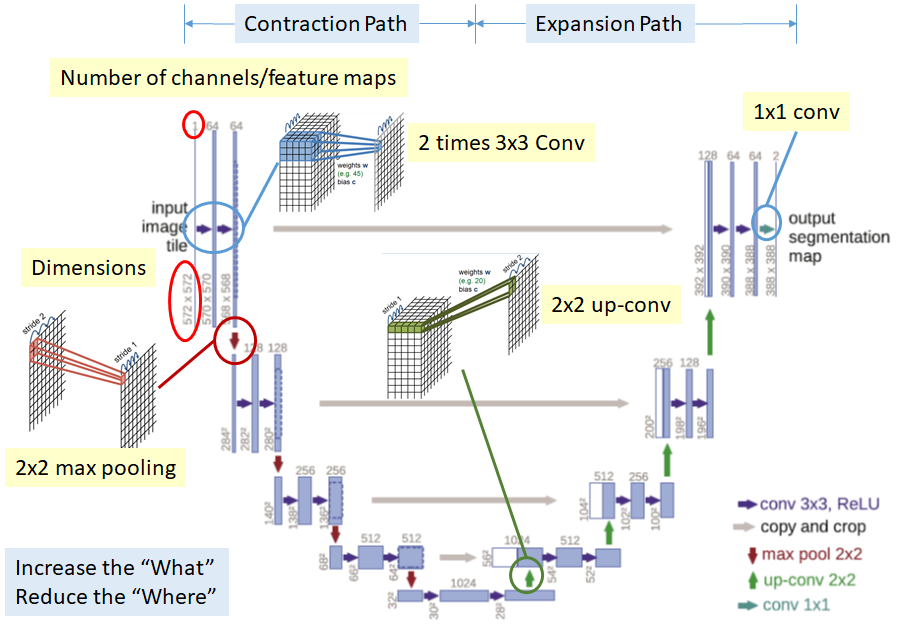

In [ ]:
import CUSTOM
from CUSTOM import simple_unet_model

In [ ]:
tf.keras.backend.clear_session()

optim = tf.keras.optimizers.Adam(0.0001)

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 
unet_model = simple_unet_model(128, 128, 128, 3, 4)
unet_model.compile(optim, total_loss, metrics=[iou_score])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [ ]:
from tensorflow.python.ops.gen_dataset_ops import model_dataset
import datetime

# !rm -rf "/content/drive/MyDrive/Brain_Tumor_Segmentation/logs"
logdir = os.path.join("/content/drive/MyDrive/Brain_Tumor_Segmentation/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

mp = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Brain_Tumor_Segmentation/Best_Unet_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score')
LR = ReduceLROnPlateau(monitor= 'val_iou_score', patience = 2, verbose= 1, mode= 'max', min_lr = 0.001)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', min_delta = 0.001, patience=3, verbose=1,mode = 'max')

callbacks = [mp, LR, ES]

In [122]:
print(os.getcwd())

image_dir = "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image/"
mask_dir = "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/"

batch_size= 2

train_dataloader= ImageDataLoader(image_dir, train_image_list, mask_dir, train_mask_list, batch_size)
test_dataloader= ImageDataLoader(image_dir, test_image_list, mask_dir, test_mask_list, batch_size)

img, msk = train_dataloader.__next__()
type(img), img[0].shape, type(msk), msk.shape

/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2


(numpy.ndarray, (128, 128, 128, 3), numpy.ndarray, (2, 128, 128, 128, 4))

In [ ]:
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(test_image_list)//batch_size

history = unet_model.fit(train_dataloader, steps_per_epoch= steps_per_epoch, epochs=30, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 1/30
137/137 [==============================] - 703s 5s/step - loss: 0.9536 - iou_score: 0.2085 - val_loss: 0.9573 - val_iou_score: 0.1823 - lr: 1.0000e-04
Epoch 2/30
137/137 [==============================] - 701s 5s/step - loss: 0.9348 - iou_score: 0.2608 - val_loss: 0.9605 - val_iou_score: 0.1869 - lr: 1.0000e-04
Epoch 3/30
137/137 [==============================] - 662s 5s/step - loss: 0.9268 - iou_score: 0.2852 - val_loss: 0.9549 - val_iou_score: 0.2069 - lr: 1.0000e-04
Epoch 4/30
137/137 [==============================] - 660s 5s/step - loss: 0.9214 - iou_score: 0.3014 - val_loss: 0.9477 - val_iou_score: 0.2375 - lr: 1.0000e-04
Epoch 5/30
137/137 [==============================] - 660s 5s/step - loss: 0.9154 - iou_score: 0.3195 - val_loss: 0.9548 - val_iou_score: 0.2402 - lr: 1.0000e-04
Epoch 6/30
137/137 [==============================] - 687s 5s/step - loss: 0.8678 - iou_score: 0.5561 - val_loss: 0.8721 - val_iou_score: 0.5342 - lr: 1.0000e-04
Epoch 7/30
137/137 [========

In [ ]:
 unet_model.save("/content/drive/MyDrive/Brain_Tumor_Segmentation/custom_unet_model.h5")

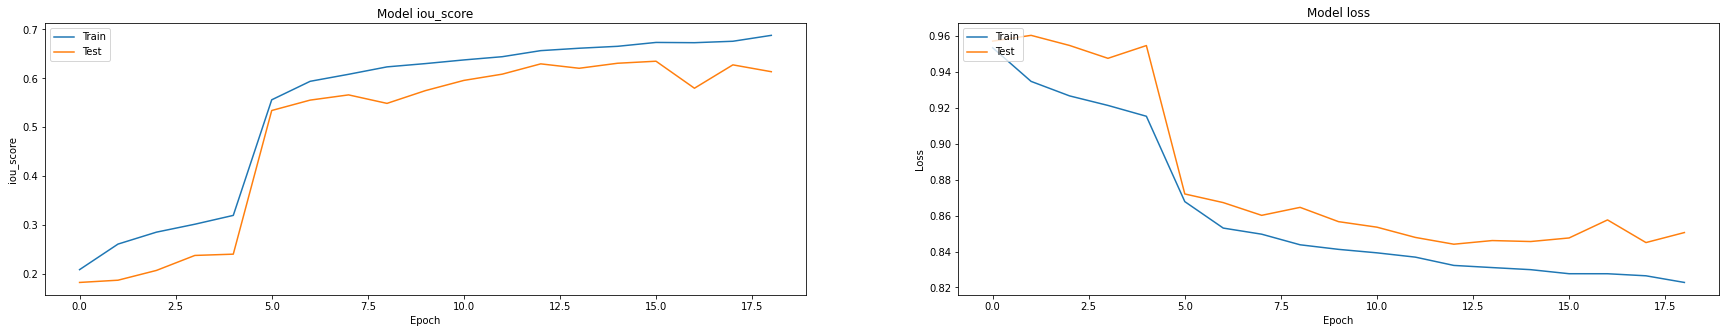

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# unet_model.load_weights("/content/custom_unet_model.h5")
# unet_model = tf.keras.models.load_model("/content/custom_unet_model.h5", compile= False)
unet_model.load_weights("/content/custom_unet_model.h5")

In [ ]:
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(test_image_list)//batch_size
unet_model.fit(train_dataloader, steps_per_epoch= steps_per_epoch, epochs=20, initial_epoch =19, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 20/20
137/137 [==============================] - 634s 4s/step - loss: 0.8234 - iou_score: 0.6894 - val_loss: 0.8504 - val_iou_score: 0.6150 - lr: 1.0000e-04


## Unet Outputs

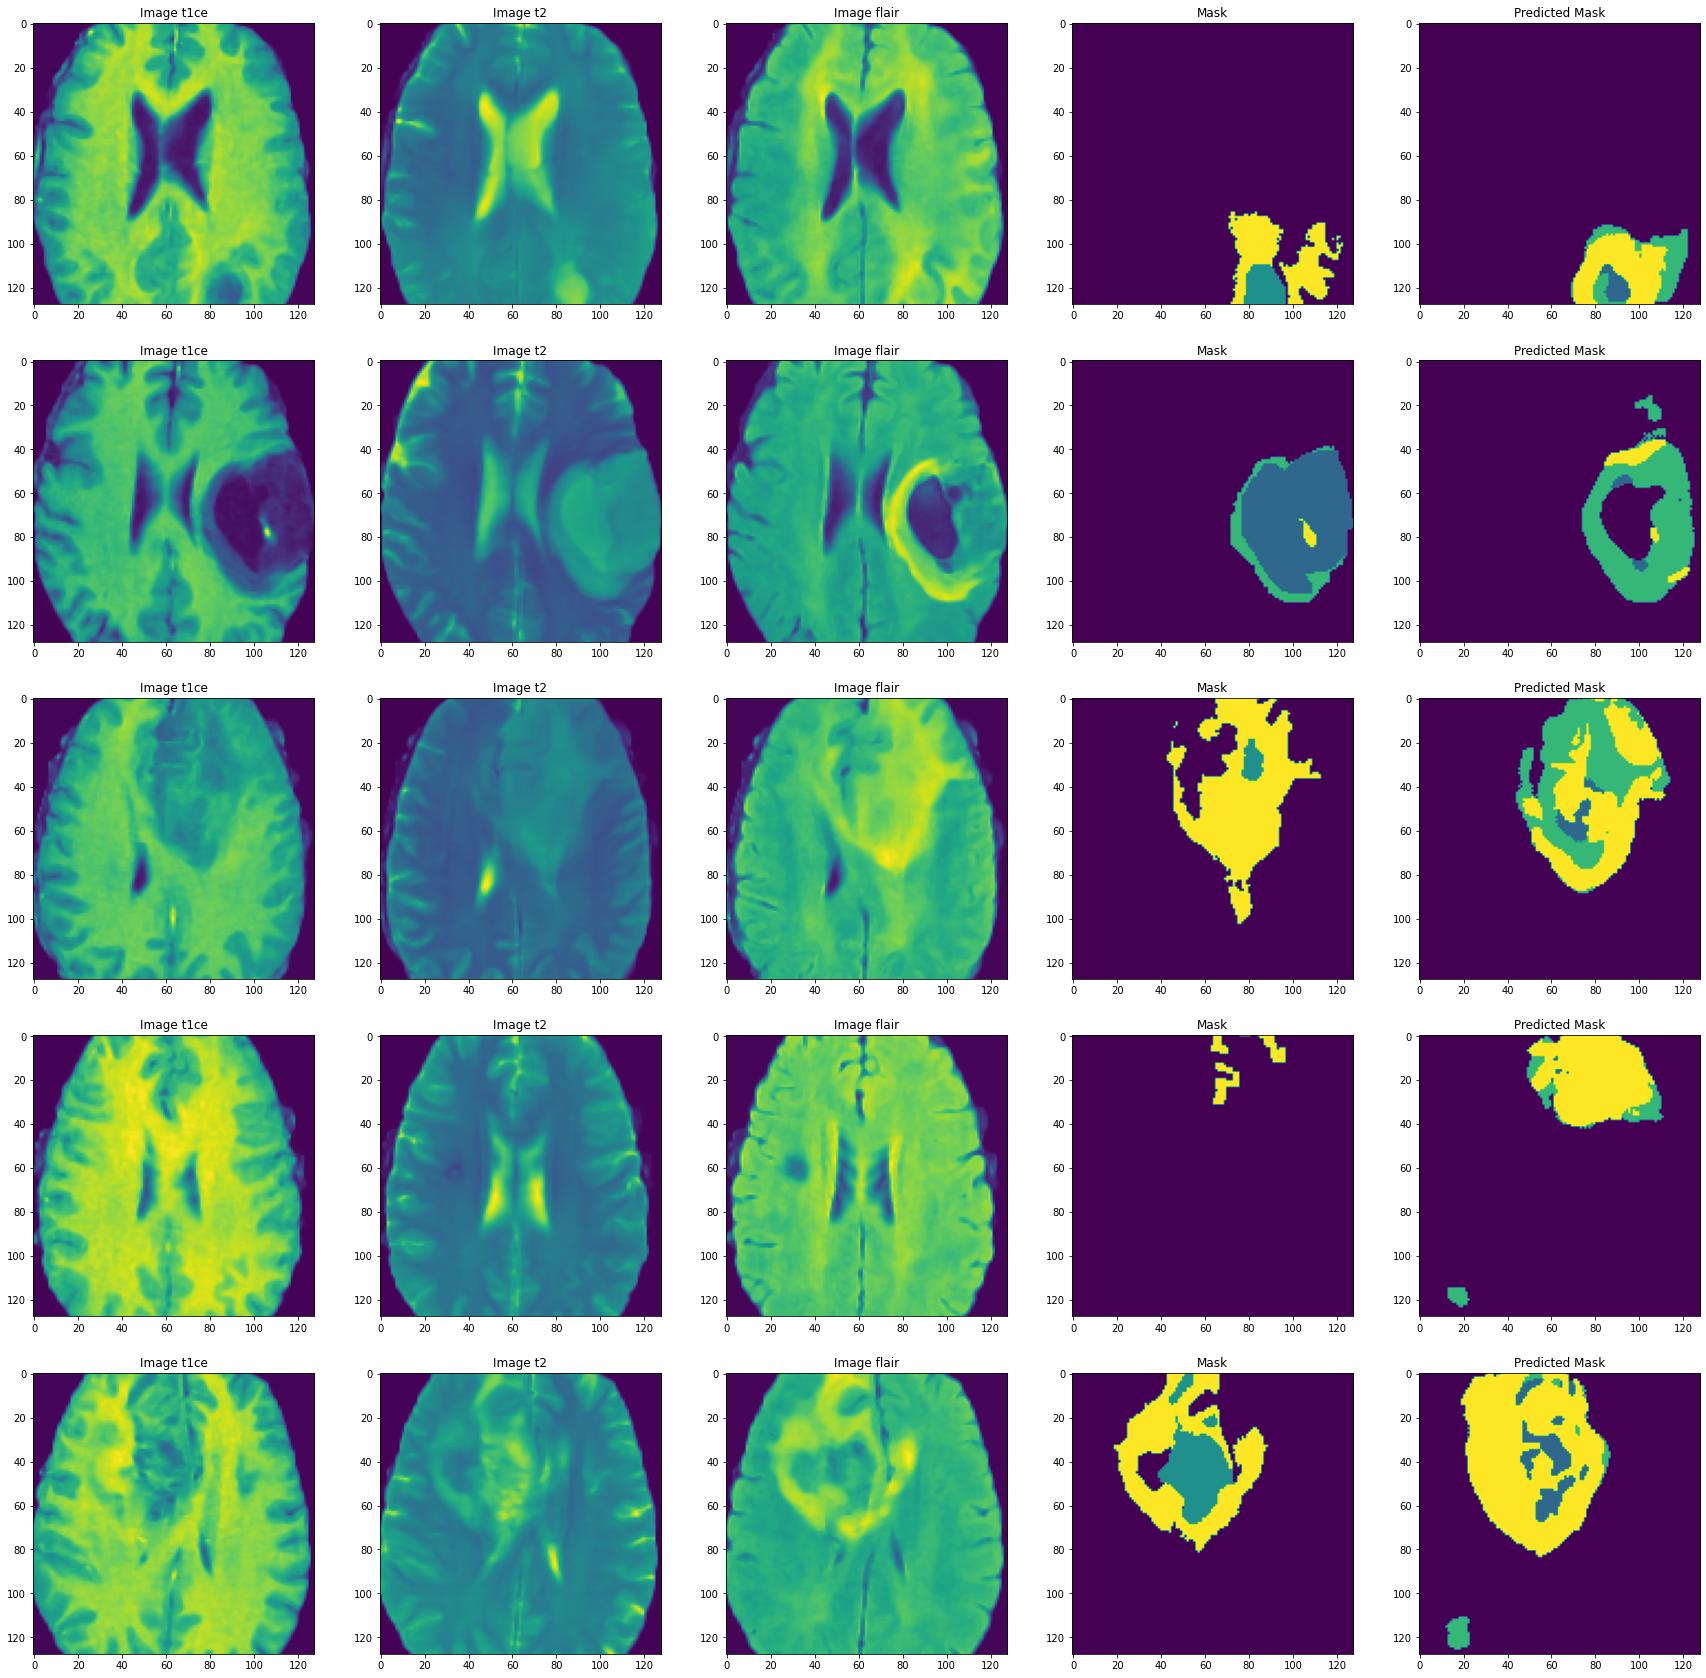

In [ ]:
fig, ax = plt.subplots(5,5, figsize = (30, 30))
unet_model.load_weights("/content/custom_unet_model.h5")
for i in range(5):
    # img = load_img(image_dir, [test_image_list[i]])
    # msk = load_img(mask_dir, [test_mask_list[i]]) 
    img, msk = test_dataloader.__next__()
    # print("Test image and mask shapes: ",img[0].shape, msk[0].shape)

    #predicting segmented images
    pred_image = unet_model.predict(img)
    
    # generating random slice number
    # n_slice = np.random.randint(img.shape[-1])
    n_slice=75

    ax[i,0].imshow(img[0][:,:,n_slice, 0])
    ax[i,0].set_title('Image t1ce')

    ax[i,1].imshow(img[0][:,:,n_slice, 1])
    ax[i,1].set_title('Image t2')

    ax[i,2].imshow(img[0][:,:,n_slice, 2])
    ax[i,2].set_title('Image flair')

    msk = np.argmax(msk[0], axis=-1)
    ax[i,3].imshow(msk[:,:,n_slice])
    ax[i,3].set_title('Mask')

    pred = np.argmax(pred_image[0], axis=-1)
    ax[i,4].imshow(pred[:,:,n_slice])
    ax[i,4].set_title('Predicted Mask')

plt.show()

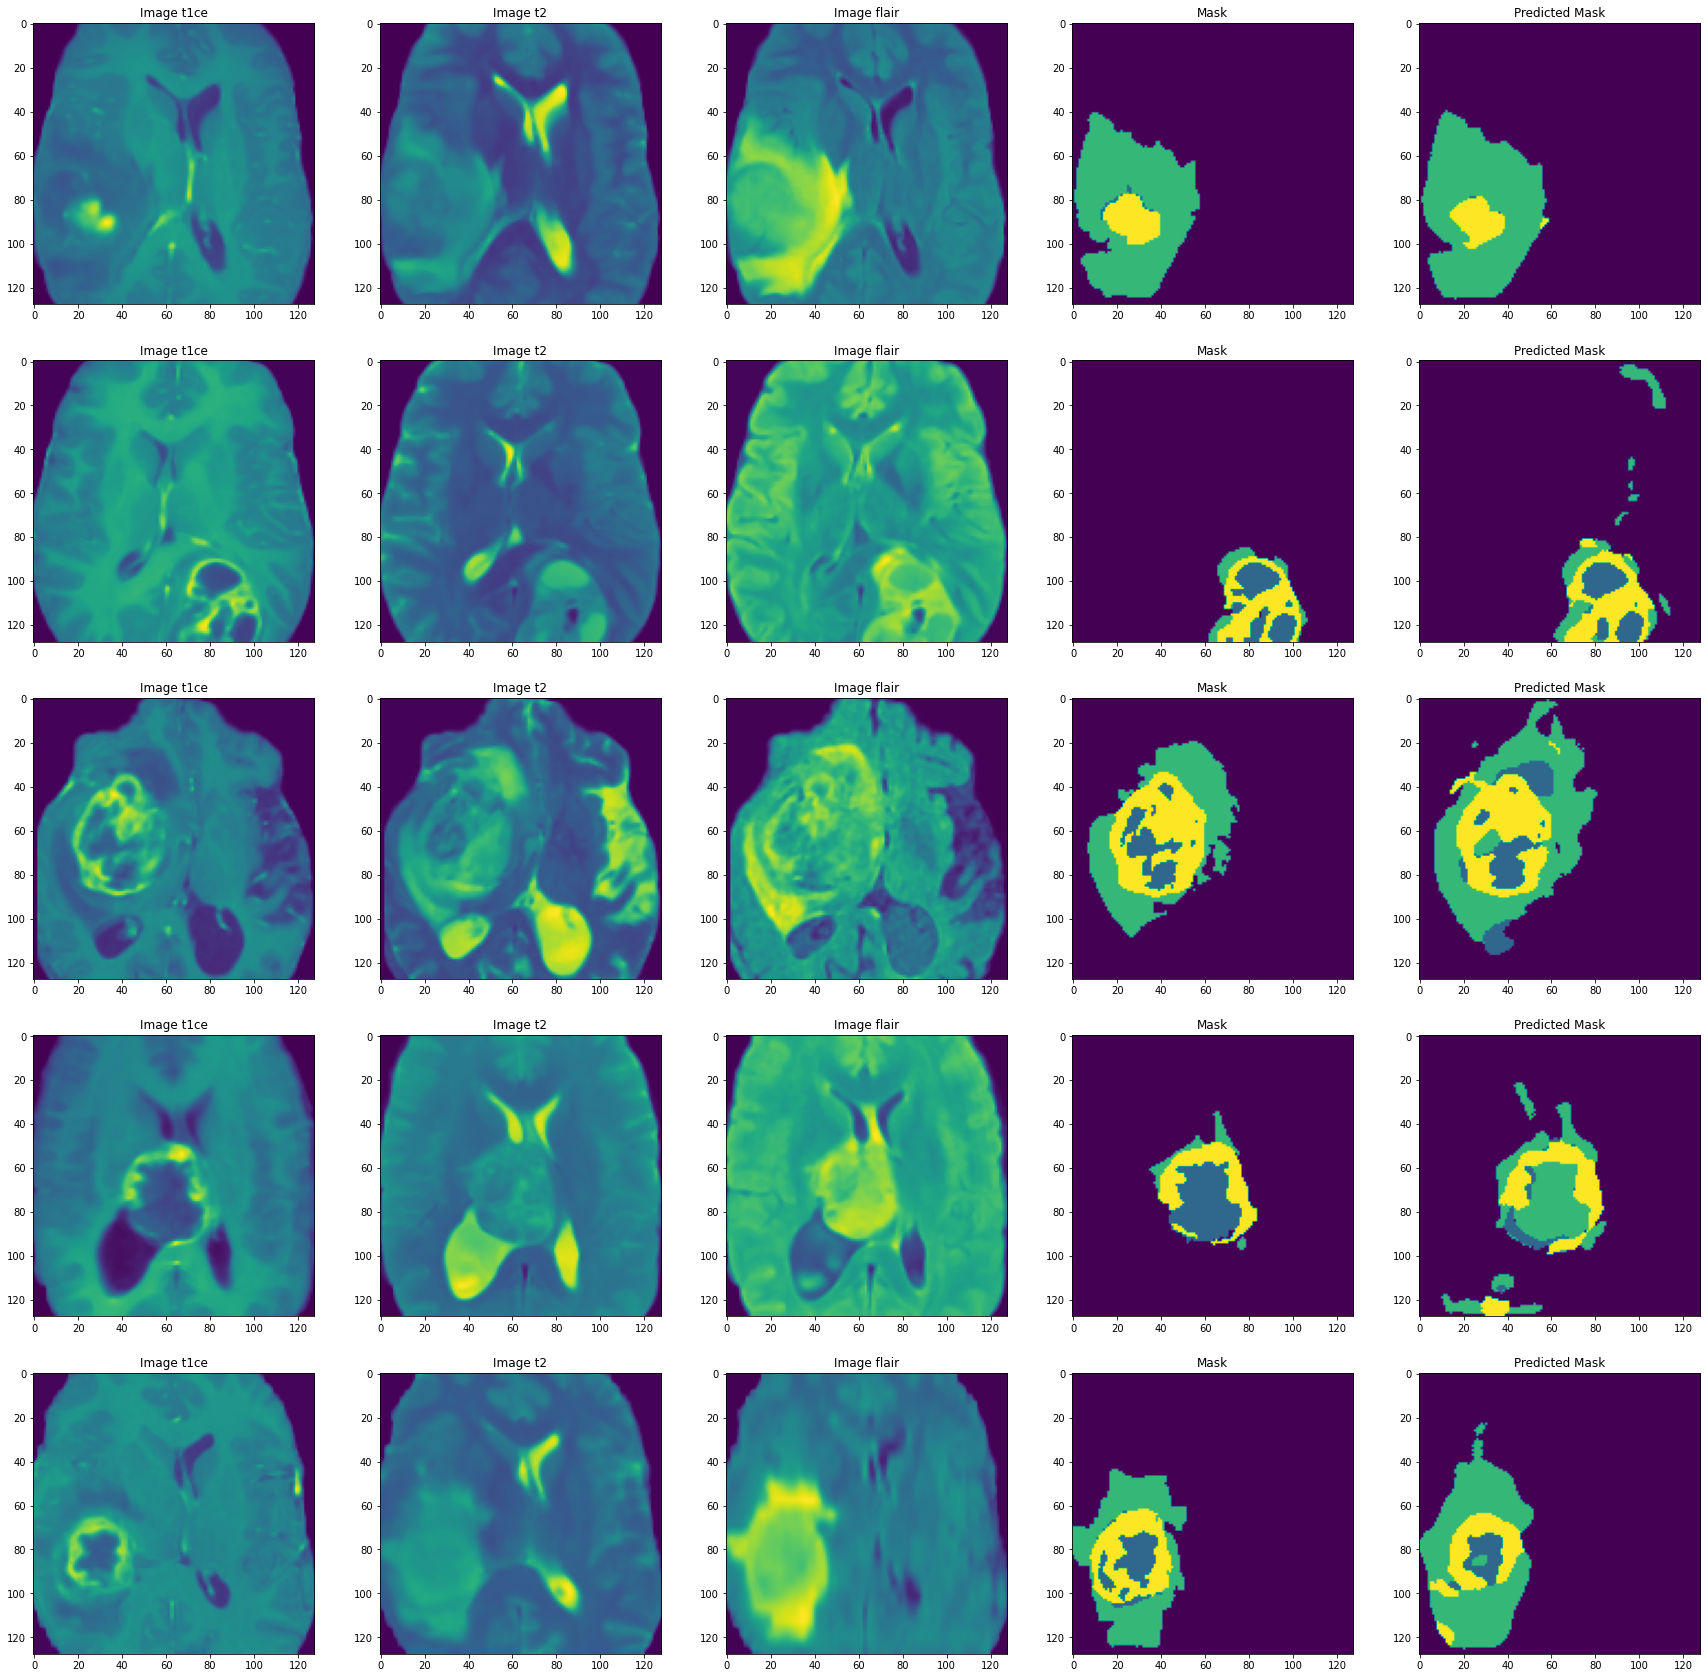

In [ ]:
fig, ax = plt.subplots(5,5, figsize = (30, 30))
unet_model.load_weights("/content/custom_unet_model.h5")

for i in range(5):
    # img = load_img(image_dir, [test_image_list[i]])
    # msk = load_img(mask_dir, [test_mask_list[i]]) 
    img, msk = test_dataloader.__next__()
    # print("Test image and mask shapes: ",img[0].shape, msk[0].shape)

    #predicting segmented images
    pred_image = unet_model.predict(img)
    
    # generating random slice number
    # n_slice = np.random.randint(img.shape[-1])
    n_slice = 65

    ax[i,0].imshow(img[0][:,:,n_slice, 0])
    ax[i,0].set_title('Image t1ce')

    ax[i,1].imshow(img[0][:,:,n_slice, 1])
    ax[i,1].set_title('Image t2')

    ax[i,2].imshow(img[0][:,:,n_slice, 2])
    ax[i,2].set_title('Image flair')

    msk = np.argmax(msk[0], axis=-1)
    ax[i,3].imshow(msk[:,:,n_slice])
    ax[i,3].set_title('Mask')

    pred = np.argmax(pred_image[0], axis=-1)
    ax[i,4].imshow(pred[:,:,n_slice])
    ax[i,4].set_title('Predicted Mask')

plt.show()

# V Net

In [ ]:
tf.keras.backend.clear_session()
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly
tf.random.set_seed(0)

from CUSTOM import Vnet_3d

vnet_model = Vnet_3d(128,128,128,3, 8,0.2)
vnet_model.compile(tf.keras.optimizers.Adam(0.01), total_loss, metrics=[iou_score])

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
print(vnet_model.input_shape)
print(vnet_model.output_shape)
vnet_model.summary()

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  3008        ['input_1[0][0]']                
                                8, 8)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   3472        ['conv3d[0][0]']                 
                                16)         

In [ ]:
import datetime
import math
# !rm -rf "/content/drive/MyDrive/Brain_Tumor_Segmentation/logs"
logdir = os.path.join("/content/drive/MyDrive/Brain_Tumor_Segmentation/vnet_logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

mp = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Brain_Tumor_Segmentation/vnet_model_2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score')
def step_decay(epoch, lrate):
    # initial_lrate = 0.01
    drop = 10^(-2)
    if epoch <5:
      lrate  = lrate
    elif (epoch>=5) and (epoch<10):
      lrate = 0.0001
    else:
       lrate = 0.00001
    return lrate
    
# LR = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
LR = ReduceLROnPlateau(monitor= 'val_iou_score', patience = 2, verbose= 1, mode= 'max')
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', min_delta = 0.001, patience=3, verbose=1,mode = 'max')

callbacks = [mp, LR, ES]

In [ ]:
image_dir = "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image/"
mask_dir = "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/masks/"

batch_size= 2

# from CUSTOM import ImageDataLoader, load_img

train_dataloader= ImageDataLoader(image_dir, train_image_list, mask_dir, train_mask_list, batch_size)
test_dataloader= ImageDataLoader(image_dir, test_image_list, mask_dir, test_mask_list, batch_size)

img, msk = train_dataloader.__next__()
len(img), img[0].shape

(2, (128, 128, 128, 3))

In [ ]:
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(test_image_list)//batch_size

history = vnet_model.fit(train_dataloader, steps_per_epoch = steps_per_epoch, epochs=30, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 1/30
137/137 [==============================] - 965s 7s/step - loss: 0.9231 - iou_score: 0.3066 - val_loss: 1.3981 - val_iou_score: 0.1229 - lr: 0.0010
Epoch 2/30
137/137 [==============================] - 950s 7s/step - loss: 0.9144 - iou_score: 0.3320 - val_loss: 1.0208 - val_iou_score: 0.2106 - lr: 0.0010
Epoch 3/30
137/137 [==============================] - 947s 7s/step - loss: 0.9109 - iou_score: 0.3395 - val_loss: 0.9737 - val_iou_score: 0.2664 - lr: 0.0010
Epoch 4/30
137/137 [==============================] - 965s 7s/step - loss: 0.9037 - iou_score: 0.3603 - val_loss: 0.9151 - val_iou_score: 0.3326 - lr: 0.0010
Epoch 5/30
137/137 [==============================] - 963s 7s/step - loss: 0.8998 - iou_score: 0.3733 - val_loss: 0.9179 - val_iou_score: 0.3325 - lr: 0.0010
Epoch 6/30
137/137 [==============================] - ETA: 0s - loss: 0.8981 - iou_score: 0.3802
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
137/137 [=======================

In [ ]:
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(test_image_list)//batch_size

vnet_model.load_weights("/content/vnet_model_2.h5")
history = vnet_model.fit(train_dataloader,initial_epoch = 6, steps_per_epoch = steps_per_epoch, epochs=30, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 7/30
137/137 [==============================] - 1352s 10s/step - loss: 0.9005 - iou_score: 0.3746 - val_loss: 0.9209 - val_iou_score: 0.3236 - lr: 0.0010
Epoch 8/30
137/137 [==============================] - 1302s 10s/step - loss: 0.8979 - iou_score: 0.3834 - val_loss: 0.9612 - val_iou_score: 0.2732 - lr: 0.0010
Epoch 9/30
137/137 [==============================] - 1301s 10s/step - loss: 0.8943 - iou_score: 0.3947 - val_loss: 0.9224 - val_iou_score: 0.3284 - lr: 0.0010
Epoch 10/30
137/137 [==============================] - 1302s 10s/step - loss: 0.8677 - iou_score: 0.5422 - val_loss: 0.8997 - val_iou_score: 0.5247 - lr: 0.0010
Epoch 11/30
115/137 [========================>.....] - ETA: 3:05 - loss: 0.8524 - iou_score: 0.5989

In [ ]:
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(test_image_list)//batch_size

vnet_model.load_weights("/content/drive/MyDrive/Brain_Tumor_Segmentation/vnet_model_2.h5")
history = vnet_model.fit(train_dataloader,initial_epoch = 10, steps_per_epoch = steps_per_epoch, epochs=30, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 11/30
137/137 [==============================] - 1011s 7s/step - loss: 0.8429 - iou_score: 0.6257 - val_loss: 0.9194 - val_iou_score: 0.5125 - lr: 0.0010
Epoch 12/30
137/137 [==============================] - 968s 7s/step - loss: 0.8397 - iou_score: 0.6345 - val_loss: 0.8715 - val_iou_score: 0.5863 - lr: 0.0010
Epoch 13/30
137/137 [==============================] - 983s 7s/step - loss: 0.8428 - iou_score: 0.6294 - val_loss: 0.9004 - val_iou_score: 0.5525 - lr: 0.0010
Epoch 14/30
137/137 [==============================] - ETA: 0s - loss: 0.8378 - iou_score: 0.6410
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
137/137 [==============================] - 990s 7s/step - loss: 0.8378 - iou_score: 0.6410 - val_loss: 0.8919 - val_iou_score: 0.5321 - lr: 0.0010
Epoch 15/30
137/137 [==============================] - 986s 7s/step - loss: 0.8351 - iou_score: 0.6510 - val_loss: 0.8608 - val_iou_score: 0.6176 - lr: 1.0000e-04
Epoch 16/30
137/137 [============

In [ ]:
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(test_image_list)//batch_size
K.set_value(vnet_model.optimizer.learning_rate, 0.0001)
  
vnet_model.load_weights("/content/vnet_model_2.h5") 
history = vnet_model.fit(train_dataloader,initial_epoch = 20, steps_per_epoch = steps_per_epoch, epochs=30, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 21/30
137/137 [==============================] - 909s 7s/step - loss: 0.8229 - iou_score: 0.6845 - val_loss: 0.8545 - val_iou_score: 0.6295 - lr: 1.0000e-04
Epoch 22/30
137/137 [==============================] - 926s 7s/step - loss: 0.8222 - iou_score: 0.6865 - val_loss: 0.8558 - val_iou_score: 0.6276 - lr: 1.0000e-04
Epoch 23/30
137/137 [==============================] - ETA: 0s - loss: 0.8222 - iou_score: 0.6866
Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
137/137 [==============================] - 927s 7s/step - loss: 0.8222 - iou_score: 0.6866 - val_loss: 0.8585 - val_iou_score: 0.6243 - lr: 1.0000e-04
Epoch 24/30
137/137 [==============================] - 926s 7s/step - loss: 0.8217 - iou_score: 0.6889 - val_loss: 0.8552 - val_iou_score: 0.6293 - lr: 1.0000e-05
Epoch 00024: early stopping


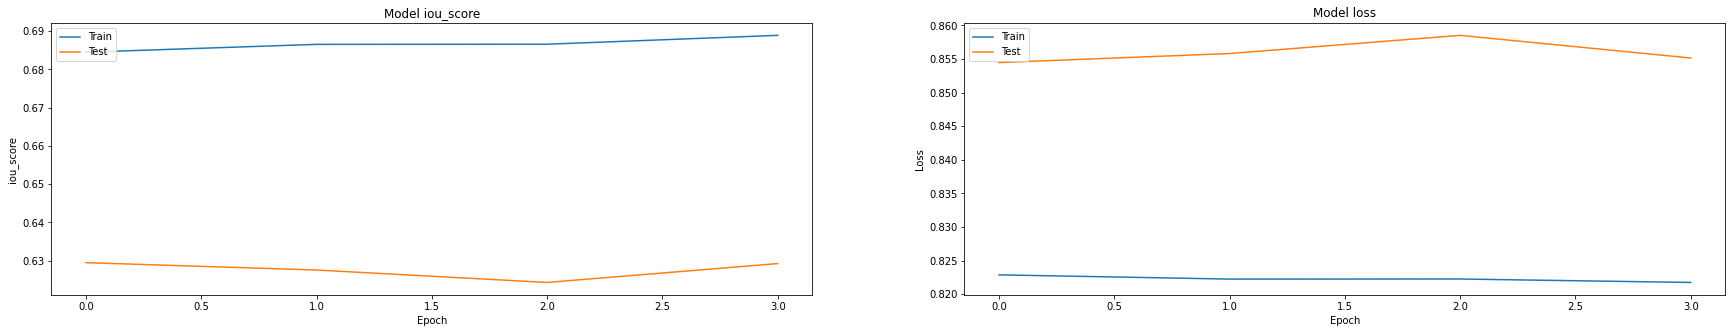

In [ ]:
# Plot training & validation iou_score values

# steps_per_epoch = len(train_image_list)//batch_size
# val_steps_per_epoch = len(test_image_list)//batch_size

# history = vnet_model.fit(train_dataloader,initial_epoch = 50, steps_per_epoch = steps_per_epoch, epochs=51, validation_data=test_dataloader, validation_steps= val_steps_per_epoch, callbacks=[ES, mp, LR])

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## VNET output

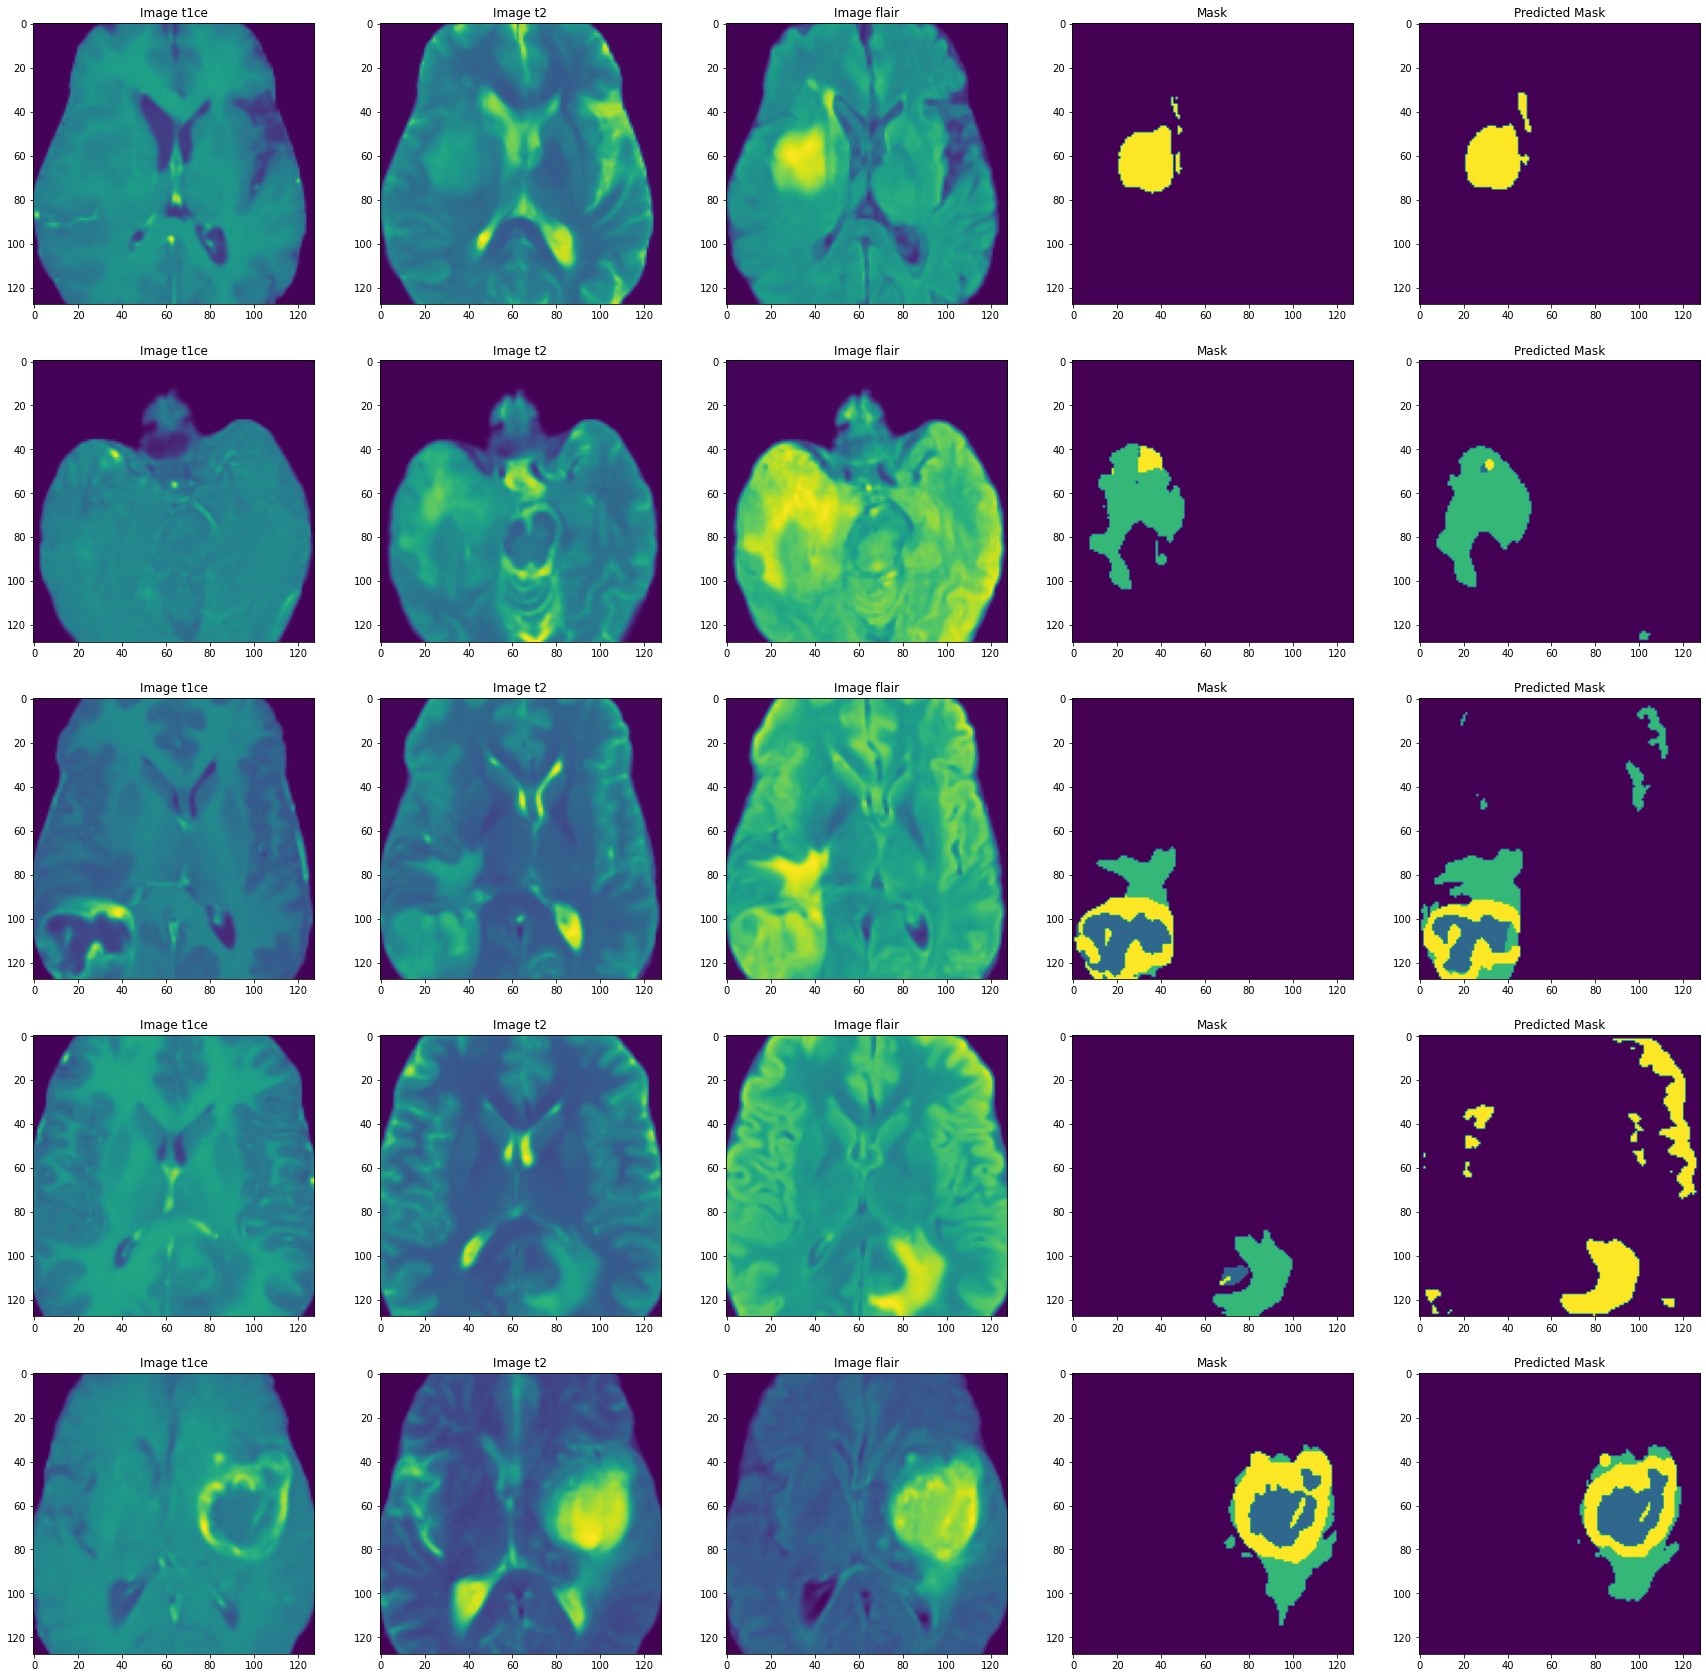

In [ ]:
fig, ax = plt.subplots(5,5, figsize = (30, 30))

vnet_model.load_weights("./vnet_model_2.h5")

for i in range(5):
    img, msk = test_dataloader.__next__() 
    #predicting segmented images
    pred_image = vnet_model.predict(img)
    
    # generating random slice number
    # n_slice = np.random.randint(img.shape[-1])
    n_slice=64

    ax[i,0].imshow(img[0][:,:,n_slice, 0])
    ax[i,0].set_title('Image t1ce')

    ax[i,1].imshow(img[0][:,:,n_slice, 1])
    ax[i,1].set_title('Image t2')

    ax[i,2].imshow(img[0][:,:,n_slice, 2])
    ax[i,2].set_title('Image flair')

    msk = np.argmax(msk[0], axis=-1)
    ax[i,3].imshow(msk[:,:,n_slice])
    ax[i,3].set_title('Mask')

    pred = np.argmax(pred_image[0], axis=-1)
    ax[i,4].imshow(pred[:,:,n_slice])
    ax[i,4].set_title('Predicted Mask')

plt.show()

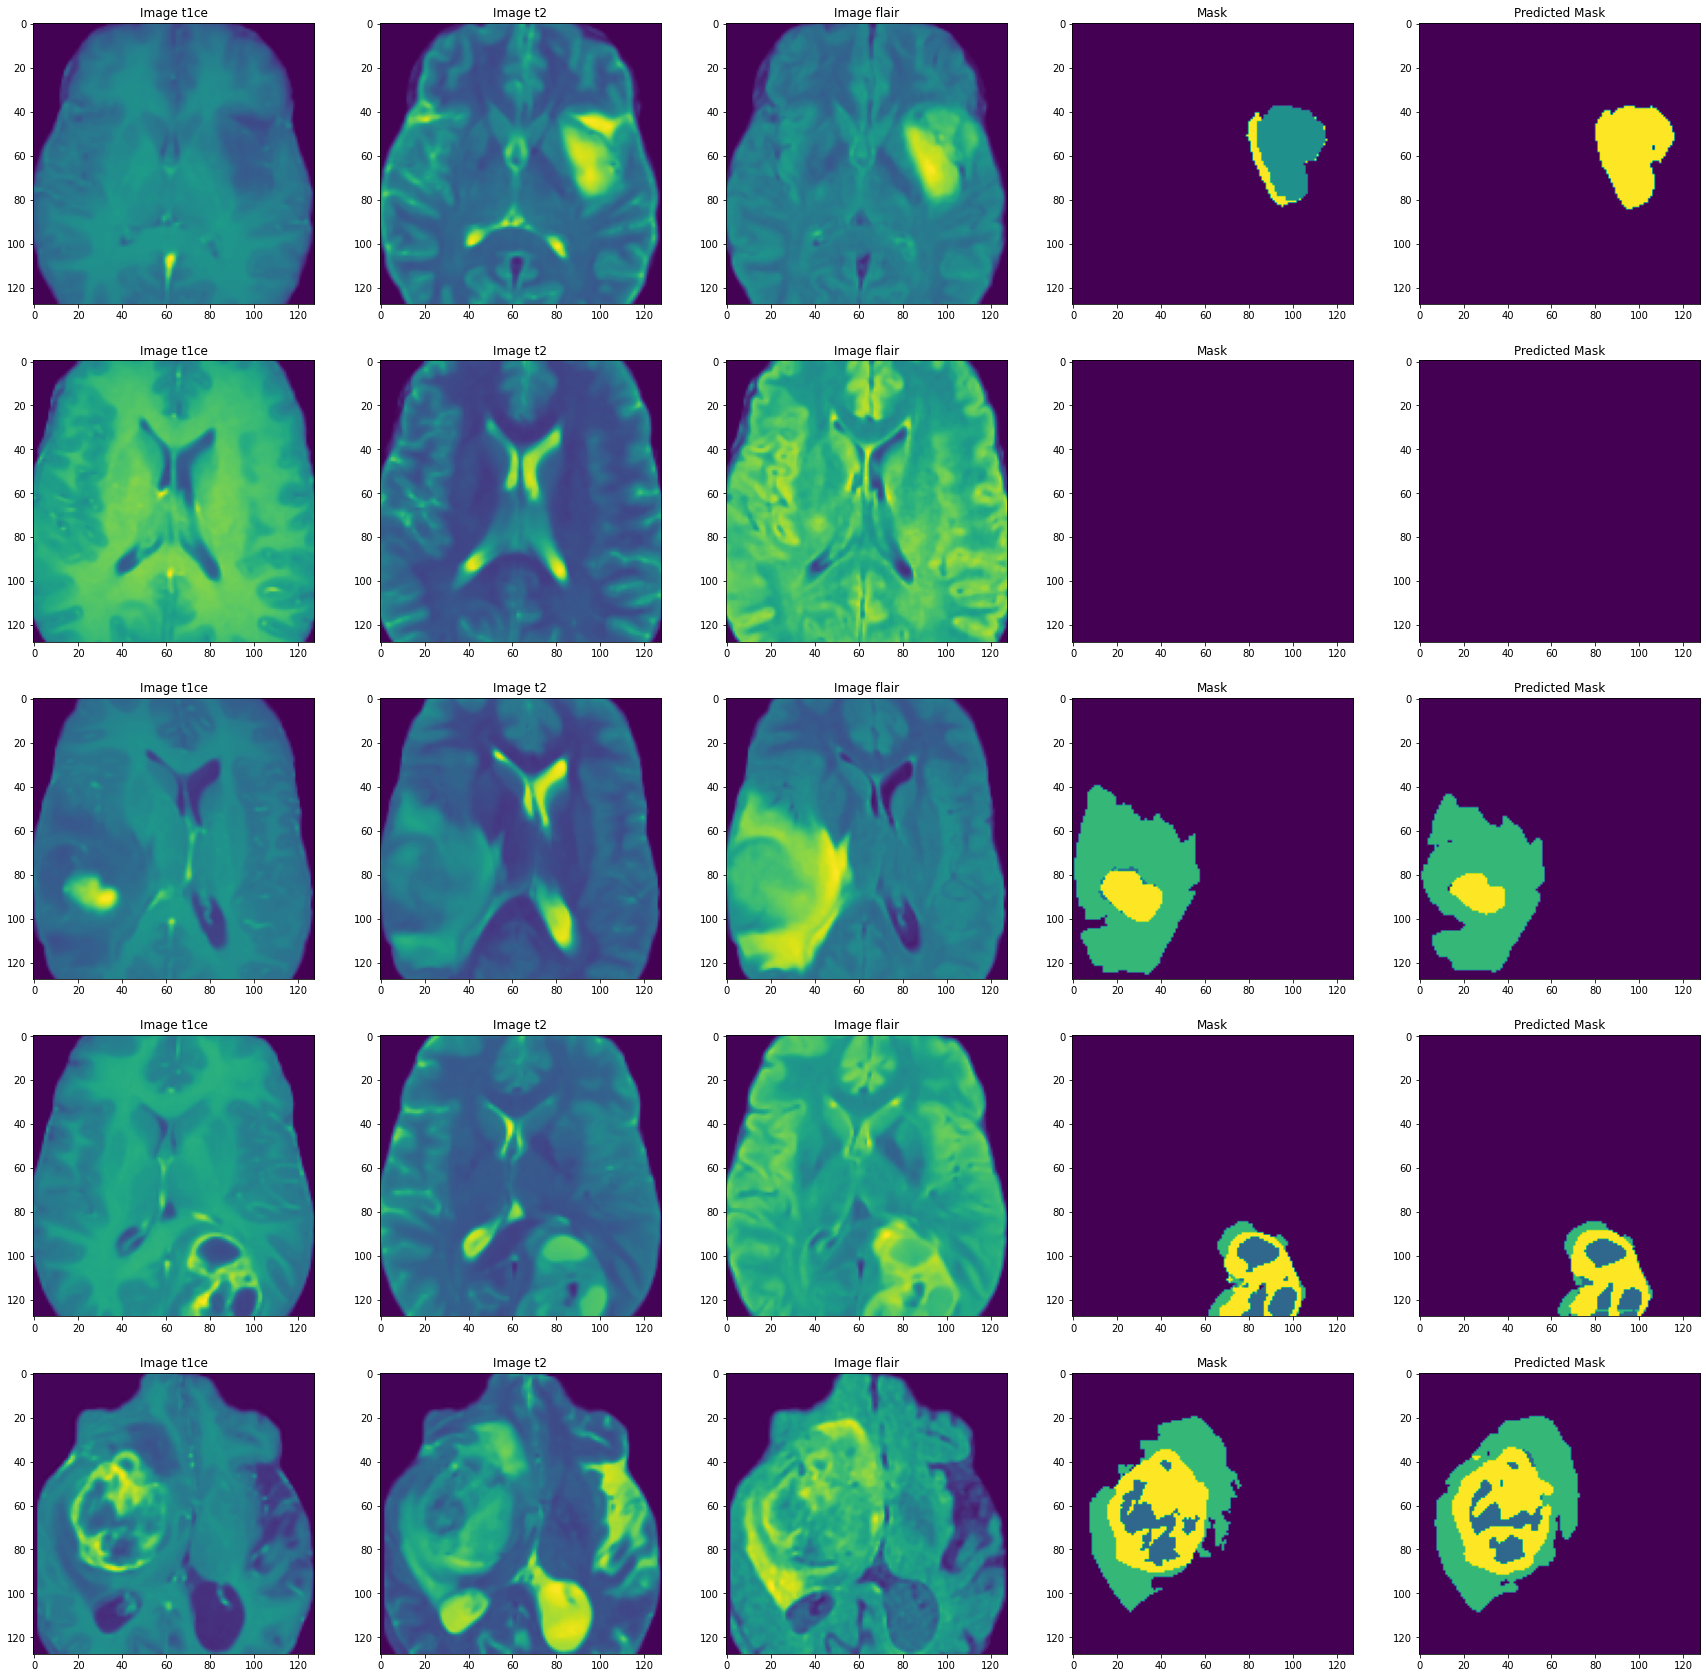

In [ ]:
fig, ax = plt.subplots(5,5, figsize = (30, 30))

vnet_model.load_weights("/content/vnet_model_2.h5")

for i in range(5):
    img, msk = test_dataloader.__next__() 
    #predicting segmented images
    pred_image = vnet_model.predict(img)
    
    # generating random slice number
    # n_slice = np.random.randint(img.shape[-1])
    n_slice=64

    ax[i,0].imshow(img[0][:,:,n_slice, 0])
    ax[i,0].set_title('Image t1ce')

    ax[i,1].imshow(img[0][:,:,n_slice, 1])
    ax[i,1].set_title('Image t2')

    ax[i,2].imshow(img[0][:,:,n_slice, 2])
    ax[i,2].set_title('Image flair')

    msk = np.argmax(msk[0], axis=-1)
    ax[i,3].imshow(msk[:,:,n_slice])
    ax[i,3].set_title('Mask')

    pred = np.argmax(pred_image[0], axis=-1)
    ax[i,4].imshow(pred[:,:,n_slice])
    ax[i,4].set_title('Predicted Mask')

plt.show()

VNET Model gives better segmentation result as compared to unet model, so we would be using Vnet model only as our final model.

# Survival Prediction (Regression)

In [53]:
data = pd.read_csv("/content/survival_info.csv")
data = data[data['Extent_of_Resection'].isnull() ==False]

In [54]:
data['Brats20ID'] = '/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image/image_'+ data['Brats20ID']+'.npy.gz'

# images present in directory
images_in_dir = glob.glob("/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image/*")
data_indices = [data[data['Brats20ID']==(i)].index[0] for i in data['Brats20ID'] if i in images_in_dir]
data = data.loc[data_indices, :]

print(data.shape)
data.head()

(117, 4)


Brats20ID  ...  Extent_of_Resection
0  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
1  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
2  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
3  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
5  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR

[5 rows x 4 columns]

In [56]:
data[data['Survival_days']=='ALIVE (361 days later)']
data["Survival_days"][83] = 361

In [57]:
# Splitting data into train and test
train, test = train_test_split(data, test_size = 0.15, random_state = 0)
print(train.shape, test.shape)

# Normalizing Age and Survival_Days
from sklearn.preprocessing import MinMaxScaler

Age_normalizer = MinMaxScaler()
train['Age'] = Age_normalizer.fit_transform(np.array(train['Age']).reshape(-1,1))
test['Age'] = Age_normalizer.transform(np.array(test['Age']).reshape(-1,1))

survival_normalizer = MinMaxScaler()
train['Survival_days'] = survival_normalizer.fit_transform(np.array(train['Survival_days']).reshape(-1,1))
test['Survival_days'] = survival_normalizer.transform(np.array(test['Survival_days']).reshape(-1,1))

train.head()

(99, 4) (18, 4)


Brats20ID  ...  Extent_of_Resection
97   /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
114  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
20   /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
227  /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR
16   /content/Brats2020Data/kaggle/working/BraTS202...  ...                  GTR

[5 rows x 4 columns]

In [128]:
# images are already preprocessed, we just need to unzip it and load it
image_dir = "/content/Brats2020Data/kaggle/working/BraTS2020_TrainingData/input_data_3channels_2/image/"

def load_img(image_list):
  images= []
  for num, i in enumerate(image_list):
    if str(i).endswith(".npy.gz"):
      image = gzip.GzipFile(i, 'r')
      images.append(np.load(image))
  return images

def ImageDataLoader( image_list,data, batch_size):

    L = len(image_list)
    print(image_list)
    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size
        

        while batch_start < L:
            limit = min(batch_end, L)
            
            X, age, Y = [], [], []
            X.append(load_img(image_list[batch_start:limit]))
            age.append(data['Age'].iloc[batch_start:limit])
            Y.append(data['Survival_days'].iloc[batch_start:limit])

            yield (np.array(X[0]),np.array(age[0])), (np.array(Y[0])) #a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end   += batch_size 
        # except:
        #   pass

batch_size = 2
train_dataloader = ImageDataLoader(list(train['Brats20ID']), train, batch_size=batch_size)
test_dataloader = ImageDataLoader(list(test['Brats20ID']), test,batch_size =batch_size)


In [132]:
tup, Y = train_dataloader.__next__()
print(type(tup[0]), tup[0][0].shape, type(tup[1]), tup[1].shape, type(Y), Y.shape )

<class 'numpy.ndarray'> (128, 128, 128, 3) <class 'numpy.ndarray'> (2,) <class 'numpy.ndarray'> (2,)


In [145]:
tf.keras.backend.clear_session()
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly
tf.random.set_seed(0)

kernel_initializer =  'he_uniform'

def SurvPredNet(input_img,age_m):
    #input_img = BatchNormalization()(input_img)
    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_img)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    a1 = Flatten()(c5)
    a1 = concatenate([a1,age_m])
    a1 = BatchNormalization()(a1)
    
    a1 = Dense(128,activation = 'relu')(a1)
    a1 = Dense(64,activation = 'relu')(a1)
    outputs = Dense(1,activation = 'sigmoid')(a1)
    
    model = Model(inputs = [input_img,age_m] , outputs = outputs)
    
    return model

In [152]:
input_img = Input((128,128,128,3))
age_m = Input((1))

model = SurvPredNet(input_img,age_m)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['mse'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_20 (Conv3D)             (None, 128, 128, 12  1312        ['input_5[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_10 (Dropout)           (None, 128, 128, 12  0           ['conv3d_20[0][0]']              
                                8, 16)                                                      

In [153]:
import datetime
import math
# !rm -rf "/content/drive/MyDrive/Brain_Tumor_Segmentation/logs"
logdir = os.path.join("/content/drive/MyDrive/Brain_Tumor_Segmentation/survival_model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

mp = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Brain_Tumor_Segmentation/survival_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_mse')
    
# LR = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
LR = ReduceLROnPlateau(monitor= 'val_mse', patience = 2, verbose= 1, mode= 'min')
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_mse', min_delta = 0.001, patience=3, verbose=1,mode = 'min')

callbacks = [mp, LR, ES]

In [154]:
steps_per_epoch = train.shape[0]/batch_size
val_steps_per_epoch = test.shape[0]/batch_size
model.fit(train_dataloader, epochs= 10, steps_per_epoch= steps_per_epoch, validation_data= test_dataloader, validation_steps= val_steps_per_epoch, callbacks=callbacks)

Epoch 1/10
49/49 [==============================] - 88s 2s/step - loss: 0.1574 - mse: 0.1574 - val_loss: 0.0457 - val_mse: 0.0457 - lr: 1.0000e-04
Epoch 2/10
49/49 [==============================] - 84s 2s/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0904 - val_mse: 0.0904 - lr: 1.0000e-04
Epoch 3/10
50/49 [==============================] - ETA: 0s - loss: 0.0670 - mse: 0.0670
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
49/49 [==============================] - 84s 2s/step - loss: 0.0670 - mse: 0.0670 - val_loss: 0.0890 - val_mse: 0.0890 - lr: 1.0000e-04
Epoch 4/10
49/49 [==============================] - 84s 2s/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0840 - val_mse: 0.0840 - lr: 1.0000e-05
Epoch 00004: early stopping


In [161]:
survival_normalizer.inverse_transform(model.predict(test_dataloader.__next__()[0]))[0]

array([52.118214], dtype=float32)

In [165]:
import pickle

survival_model_files= open('/content/drive/MyDrive/Brain_Tumor_Segmentation/survival_model_files', 'rb')
Age_normalizer, survival_normalizer= pickle.load(survival_model_files)
# pickle.dump((Age_normalizer, survival_normalizer), survival_model_files)